# Si Data Tuh Notebook
### made by
###### Mudzaki K Hakim
###### Ghazy Achmed M Urbayani
###### Mahesa F Andre

## Import Library

In [ ]:

import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, MinMaxScaler
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor
import joblib
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings('ignore')
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
RANDOM_STATE = 42

## Import Dataset

In [ ]:
train_df = pd.read_csv('train_dataset.csv')
test_df = pd.read_csv('test_dataset.csv')

## Exploratory Data Analysis

In [ ]:
# Cek persentase null untuk train dataset
print("Train Dataset - Persentase Missing Values:")
train_null_percentage = (train_df.isnull().sum() / len(train_df)) * 100
print(train_null_percentage[train_null_percentage > 0].sort_values(ascending=False))

print("\n" + "="*50 + "\n")

# Cek persentase null untuk test dataset
print("Test Dataset - Persentase Missing Values:")
test_null_percentage = (test_df.isnull().sum() / len(test_df)) * 100
print(test_null_percentage[test_null_percentage > 0].sort_values(ascending=False))

Train Dataset - Persentase Missing Values:
school_type                12.500
percent_low_income         12.250
internet_access_percent    11.375
school_name                11.000
funding_per_student_usd    10.875
state                       9.750
grade_level                 9.625
student_teacher_ratio       9.375
percent_minority            9.125
avg_test_score_percent      8.875
dtype: float64


Test Dataset - Persentase Missing Values:
percent_minority           10.0
percent_low_income          9.5
state                       8.0
school_type                 6.5
avg_test_score_percent      6.5
school_name                 5.5
student_teacher_ratio       5.5
grade_level                 4.5
funding_per_student_usd     4.5
internet_access_percent     4.5
dtype: float64


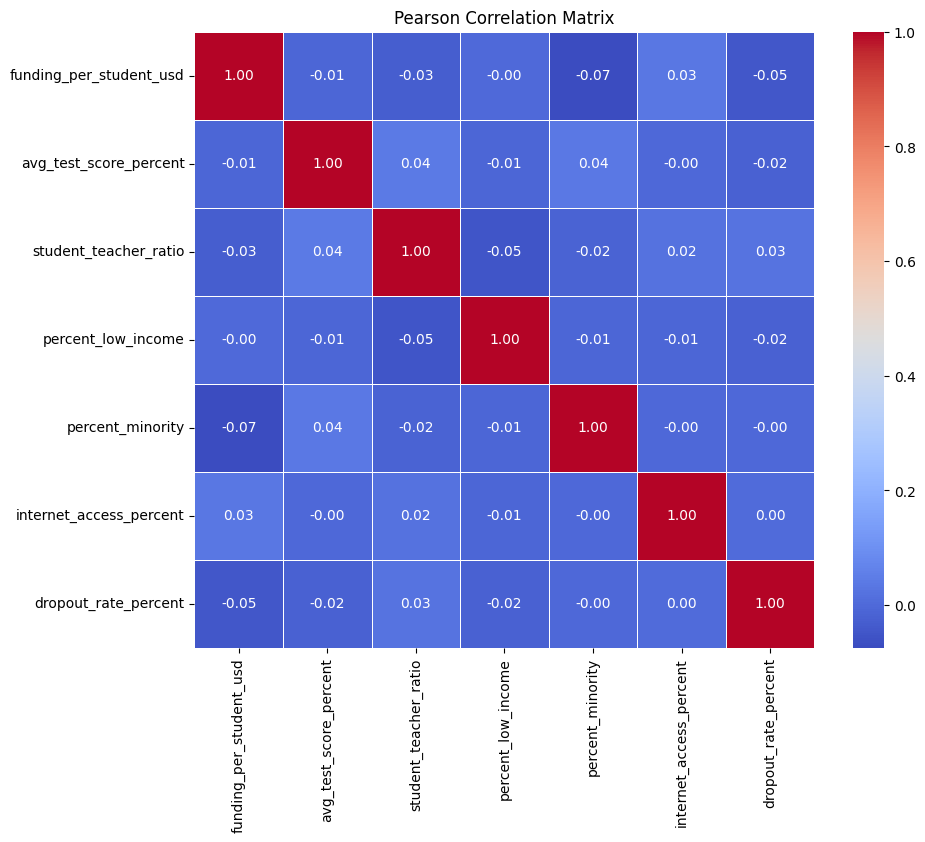

In [ ]:

correlation_matrix = train_df.corr(method='pearson', numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Pearson Correlation Matrix')
plt.show()

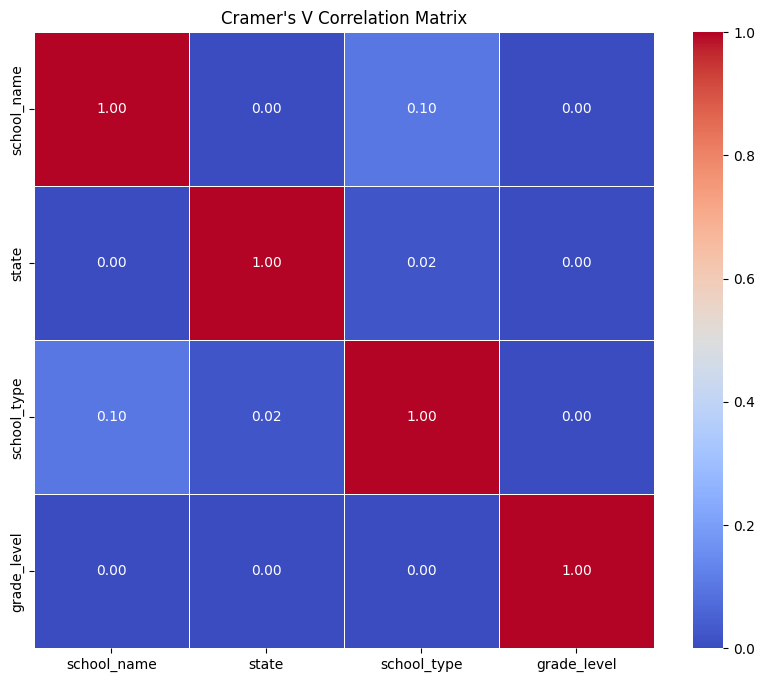

In [ ]:

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

categorical_cols = train_df.select_dtypes(include='object').columns

cramer_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

for col1 in categorical_cols:
    for col2 in categorical_cols:
        cramer_matrix.loc[col1, col2] = cramers_v(train_df[col1], train_df[col2])

cramer_matrix = cramer_matrix.apply(pd.to_numeric)
plt.figure(figsize=(10, 8))
sns.heatmap(cramer_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Cramer's V Correlation Matrix")
plt.show()

Cramer's V with dropout_rate_percent:




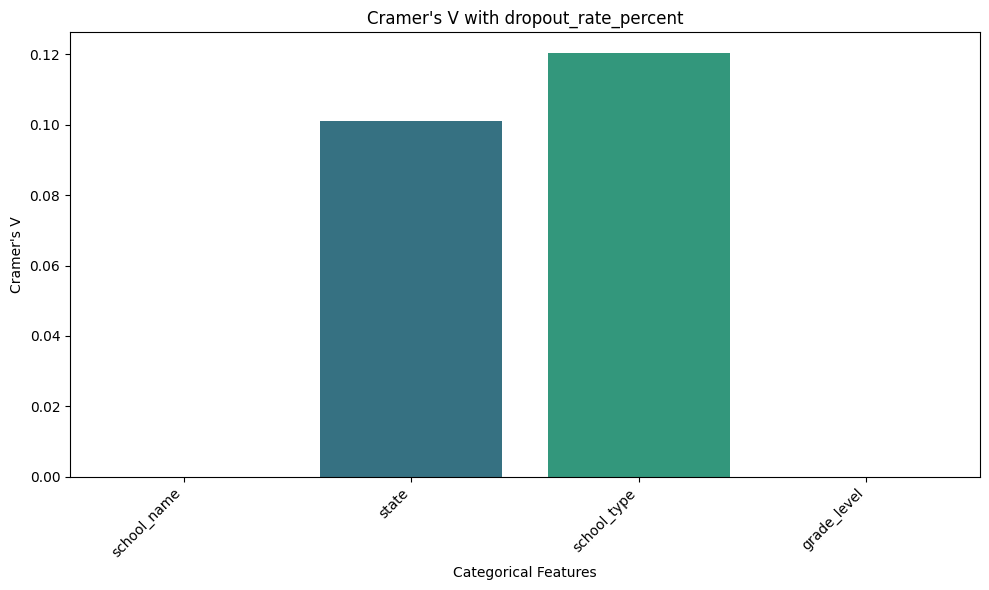

In [ ]:
# Calculate Cramer's V between categorical columns and the target variable
categorical_cols = train_df.select_dtypes(include='object').columns
target_col = 'dropout_rate_percent'

cramer_v_with_target = {}
for col in categorical_cols:
    if col != target_col:
        cramer_v_with_target[col] = cramers_v(train_df[col], train_df[target_col])

print("Cramer's V with dropout_rate_percent:")


print("\n" + "="*50 + "\n")

numerical_cols = train_df.select_dtypes(include=np.number).columns
pearson_corr_with_target = train_df[numerical_cols].corr(method='pearson')[target_col].drop(target_col)
plt.figure(figsize=(10, 6))
cramer_series = pd.Series(cramer_v_with_target)
sns.barplot(x=cramer_series.index, y=cramer_series.values, palette='viridis')
plt.title("Cramer's V with dropout_rate_percent")
plt.ylabel("Cramer's V")
plt.xlabel("Categorical Features")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

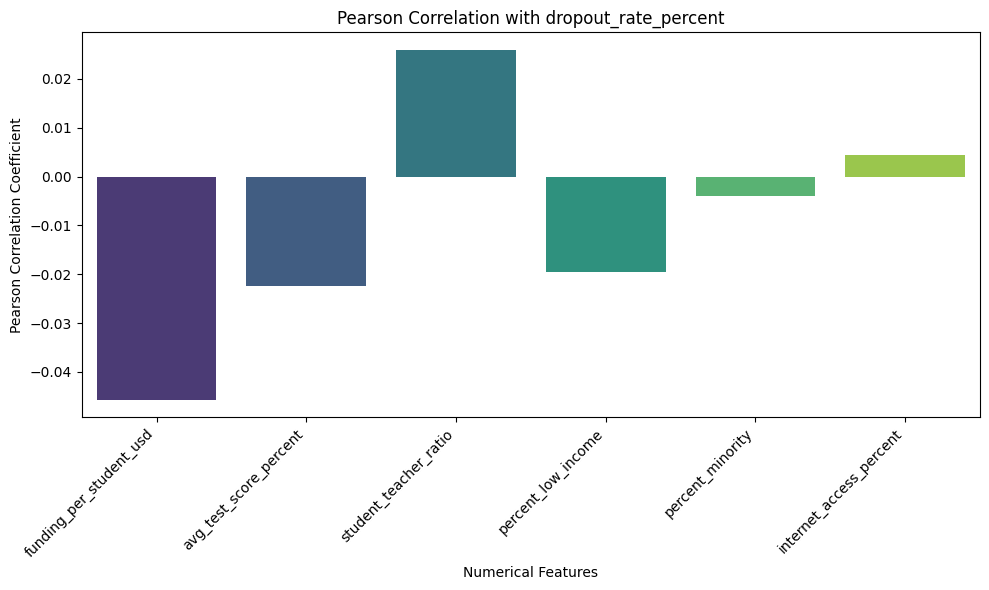

In [ ]:

plt.figure(figsize=(10, 6))
sns.barplot(x=pearson_corr_with_target.index, y=pearson_corr_with_target.values, palette='viridis')
plt.title("Pearson Correlation with dropout_rate_percent")
plt.ylabel("Pearson Correlation Coefficient")
plt.xlabel("Numerical Features")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

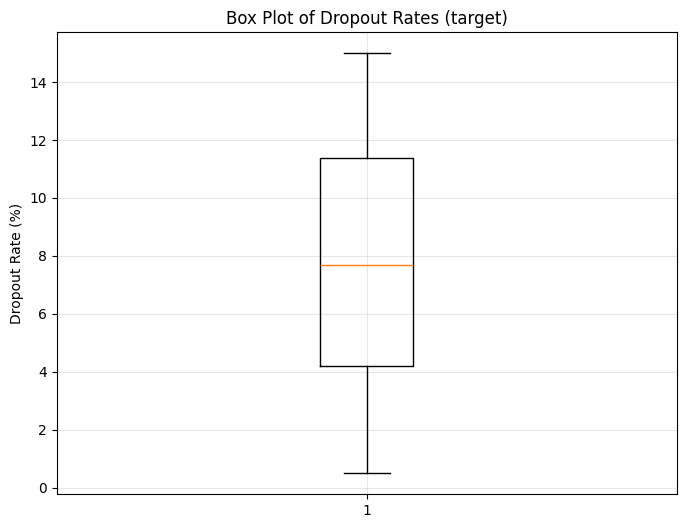

Summary Statistics for target:
Mean: 7.73
Median: 7.70
Std: 4.16
Min: 0.50
Max: 14.99
25th percentile (Q1): 4.22
75th percentile (Q3): 11.39
Count below 25th percentile: 200
Count above 75th percentile: 200


In [ ]:

target = train_df['dropout_rate_percent']
plt.figure(figsize=(8, 6))
plt.boxplot(target, vert=True)
plt.ylabel('Dropout Rate (%)')
plt.title('Box Plot of Dropout Rates (target)')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Summary Statistics for target:")
print(f"Mean: {target.mean():.2f}")
print(f"Median: {target.median():.2f}")
print(f"Std: {target.std():.2f}")
print(f"Min: {target.min():.2f}")
print(f"Max: {target.max():.2f}")
# Calculate percentiles
q25 = target.quantile(0.25)
q75 = target.quantile(0.75)

count_below_q25 = (target < q25).sum()
count_above_q75 = (target > q75).sum()

print(f"25th percentile (Q1): {q25:.2f}")
print(f"75th percentile (Q3): {q75:.2f}")
print(f"Count below 25th percentile: {count_below_q25}")
print(f"Count above 75th percentile: {count_above_q75}")

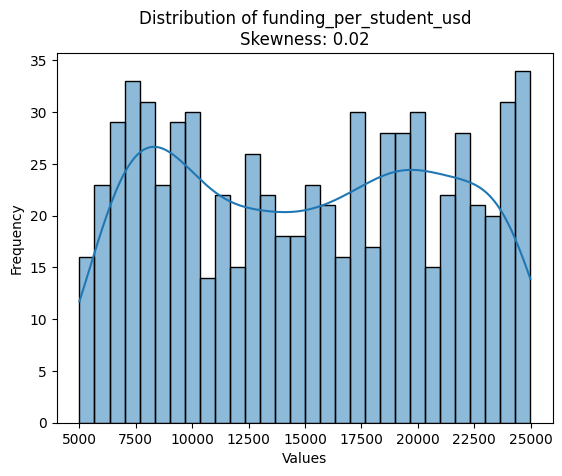

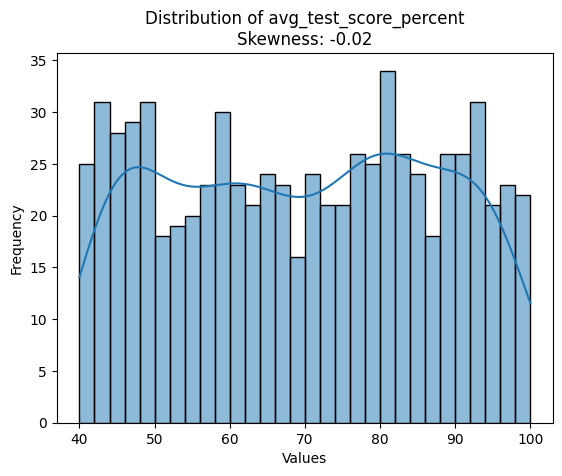

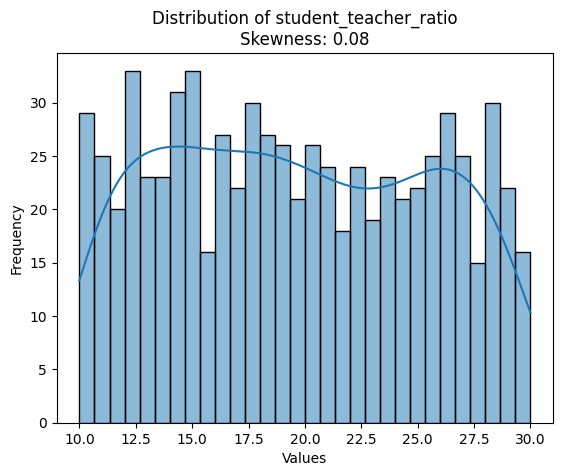

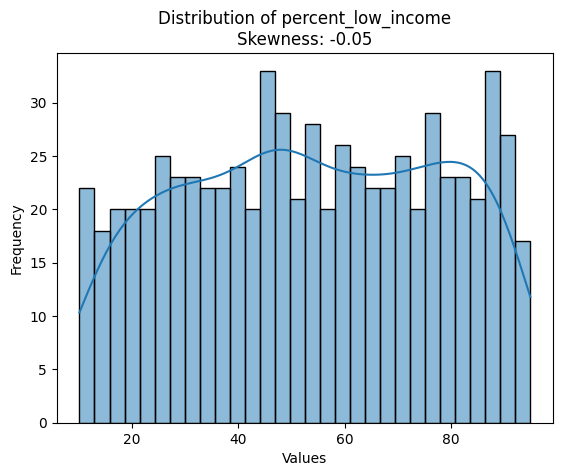

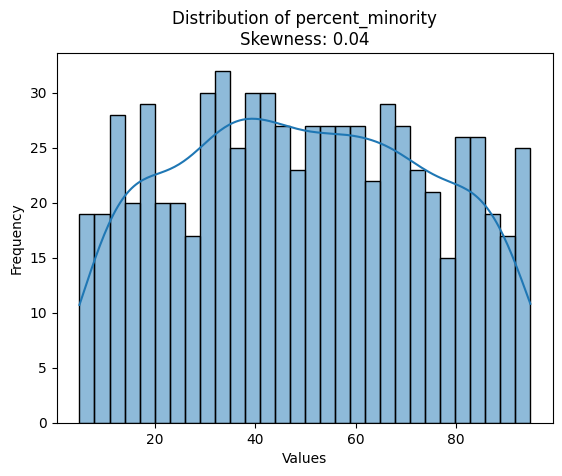

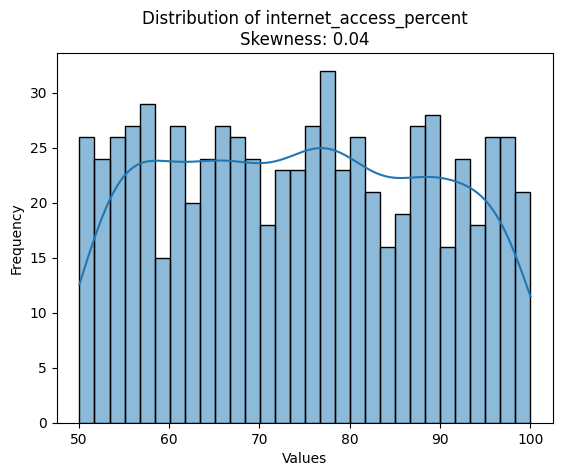

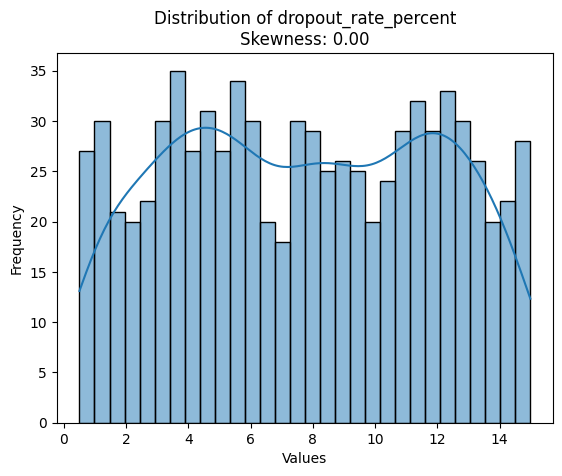

In [ ]:
numerical_cols = train_df.select_dtypes(include=np.number).columns
skewness = train_df[numerical_cols].skew().sort_values(ascending=False)

for col in numerical_cols:
  sns.histplot(train_df[col], kde=True, bins=30)
  plt.title(f'Distribution of {col}\nSkewness: {skewness[col]:.2f}') # Add skewness to title
  plt.xlabel('Values')
  plt.ylabel('Frequency')
  plt.show()

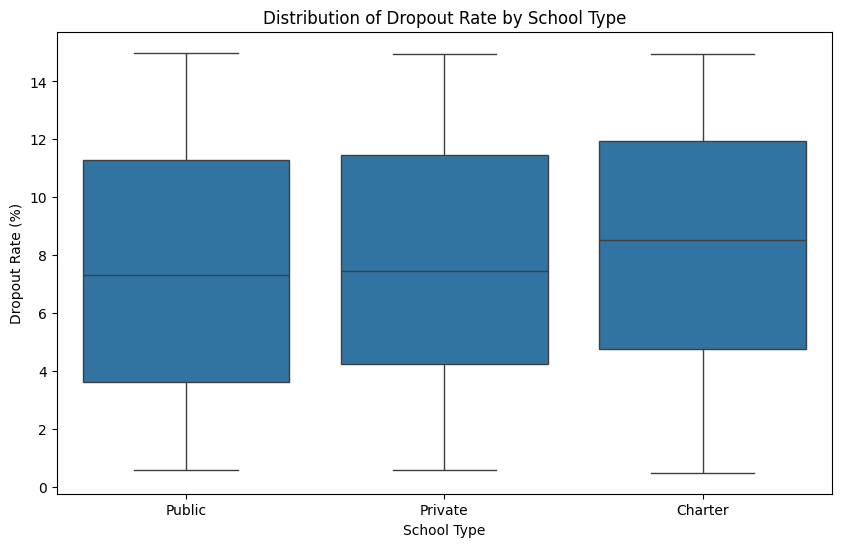

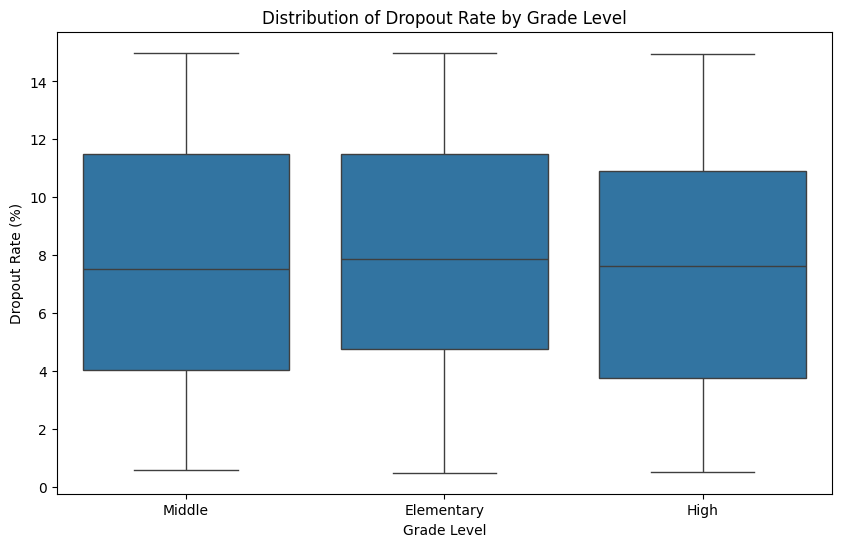

In [ ]:
# Box plot of dropout_rate_percent by school_type
plt.figure(figsize=(10, 6))
sns.boxplot(x='school_type', y='dropout_rate_percent', data=train_df)
plt.title('Distribution of Dropout Rate by School Type')
plt.xlabel('School Type')
plt.ylabel('Dropout Rate (%)')
plt.show()

# Box plot of dropout_rate_percent by grade_level
plt.figure(figsize=(10, 6))
sns.boxplot(x='grade_level', y='dropout_rate_percent', data=train_df)
plt.title('Distribution of Dropout Rate by Grade Level')
plt.xlabel('Grade Level')
plt.ylabel('Dropout Rate (%)')
plt.show()

## Feature Engineering, Preprocessing, and Modeling

#### SUBMISI 1

In [ ]:
# the Best 3.7327 GradientBoosting MinMaxScaler MeanImputer


# --- 1. Memuat Data ---
try:
    train_df = pd.read_csv('train_dataset.csv')
    test_df = pd.read_csv('test_dataset.csv')
    print("Data berhasil dimuat.")
except FileNotFoundError as e:
    print(f"Error: Gagal memuat file. Pastikan 'train_dataset.csv' dan 'test_dataset.csv' ada. Detail: {e}")
    exit()

# --- 2. Persiapan Data ---
train_df.dropna(subset=['dropout_rate_percent'], inplace=True)
X_train = train_df.drop('dropout_rate_percent', axis=1)
y_train = train_df['dropout_rate_percent']
X_test = test_df.copy()
categorical_features_pre_fe = X_train.select_dtypes(include=['object']).columns.tolist()

# --- 3. Definisi Feature Engineering Transformer ---
class SelectableFeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, include_features=None):
        self.include_features = include_features if include_features is not None else []

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        df = X.copy()
        # Selalu buat semua fitur yang mungkin dibutuhkan oleh pipeline
        df['funding_per_teacher'] = df['funding_per_student_usd'] * df['student_teacher_ratio']
        df['low_income_minority_interaction'] = df['percent_low_income'] * df['percent_minority']
        df['score_to_funding_ratio'] = df['avg_test_score_percent'] / (df['funding_per_student_usd'] + 1e-6)
        df['is_high_school'] = df['school_name'].str.contains('High', case=False, na=False).astype(int)
        df['is_middle_school'] = df['school_name'].str.contains('Middle', case=False, na=False).astype(int)
        df['is_elementary_school'] = df['school_name'].str.contains('Elementary', case=False, na=False).astype(int)
        df['minority_to_internet_gap'] = df['percent_minority'] - df['internet_access_percent']
        return df

print("Membangun pipeline dengan konfigurasi yang ditentukan...")

# Konfigurasi yang ditentukan
specific_features = [
    'is_high_school', 'is_middle_school', 'is_elementary_school', 'funding_per_teacher',
    'low_income_minority_interaction', 'score_to_funding_ratio', 'minority_to_internet_gap'
]

all_possible_new_features = [
    'funding_per_teacher', 'low_income_minority_interaction', 'score_to_funding_ratio',
    'is_high_school', 'is_middle_school', 'is_elementary_school', 'minority_to_internet_gap'
]
initial_numerical_features = X_train.select_dtypes(include=np.number).columns.drop('id', errors='ignore').tolist()
final_numerical_features = initial_numerical_features + all_possible_new_features


numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categorical_features_to_encode = [col for col in categorical_features_pre_fe if col != 'school_name']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, final_numerical_features),
        ('cat', categorical_transformer, categorical_features_to_encode)
    ],
    remainder='drop'
)
final_pipeline = Pipeline(steps=[
    ('feature_engineering', SelectableFeatureEngineeringTransformer(include_features=specific_features)),
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

scores = cross_val_score(final_pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

mae_scores = -scores

print(f"Skor MAE untuk setiap fold: {mae_scores}")
print(f"MAE rata-rata dari 5-fold CV: {mae_scores.mean():.4f}")
print(f"Standar deviasi MAE dari 5-fold CV: {mae_scores.std():.4f}")
print("Melatih model final...")
final_pipeline.fit(X_train, y_train)

print("Membuat prediksi")
final_predictions = final_pipeline.predict(X_test)

submission_df = pd.DataFrame({'id': X_test['id'], 'dropout_rate_percent': final_predictions})
submission_df.to_csv('submission.csv', index=False)
print("\nFile 'submission.csv' berhasil dibuat dengan konfigurasi terbaik.")

Data berhasil dimuat.
Membangun pipeline dengan konfigurasi yang ditentukan...
Skor MAE untuk setiap fold: [3.74445043 3.6212109  3.97861376 4.00491795 3.76230933]
MAE rata-rata dari 5-fold CV: 3.8223
Standar deviasi MAE dari 5-fold CV: 0.1469
Melatih model final...
Membuat prediksi

File 'submission.csv' berhasil dibuat dengan konfigurasi terbaik.


#### SUBMISI 2

In [ ]:


# --- 2. Memuat Data ---
try:
    train_df = pd.read_csv('train_dataset.csv')
    test_df = pd.read_csv('test_dataset.csv')
    print("Data berhasil dimuat.")
except FileNotFoundError as e:
    print(f"Error: Gagal memuat file. Detail: {e}")
    exit()

# --- 3. Persiapan Data ---
train_df.dropna(subset=['dropout_rate_percent'], inplace=True)
X_train = train_df.drop('dropout_rate_percent', axis=1)
y_train = train_df['dropout_rate_percent']
X_test = test_df.copy()
categorical_features_pre_fe = X_train.select_dtypes(include=['object']).columns.tolist()

# --- 4. Definisi Feature Engineering Transformer (Tetap Sama) ---
class SelectableFeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, include_features=None):
        self.include_features = include_features if include_features is not None else []
    def fit(self, X, y=None): return self
    def transform(self, X, y=None):
        df = X.copy()
        # Semua fitur potensial didefinisikan di sini
        df['funding_per_teacher'] = df['funding_per_student_usd'] * df['student_teacher_ratio']
        df['low_income_minority_interaction'] = df['percent_low_income'] * df['percent_minority']
        df['score_to_funding_ratio'] = df['avg_test_score_percent'] / (df['funding_per_student_usd'] + 1e-6)
        df['is_high_school'] = df['school_name'].str.contains('High', case=False, na=False).astype(int)
        df['is_middle_school'] = df['school_name'].str.contains('Middle', case=False, na=False).astype(int)
        df['is_elementary_school'] = df['school_name'].str.contains('Elementary', case=False, na=False).astype(int)
        df['teacher_load'] = 1 / (df['student_teacher_ratio'] + 1 + 1e-6)
        df['minority_to_internet_gap'] = df['percent_minority'] - df['internet_access_percent']

        # Mengembalikan DataFrame dengan semua kolom, fitur yang tidak terpilih tidak akan digunakan oleh preprocessor
        return df

# --- 5. Mendefinisikan Fungsi & Konfigurasi untuk Ensemble ---

# A. Fungsi untuk membuat pipeline secara dinamis
def create_pipeline(config):
    # Dapatkan daftar kolom numerik setelah FE.
    # Kita buat dataframe sementara untuk mengecek kolom apa saja yang ada
    temp_transformer = SelectableFeatureEngineeringTransformer(include_features=config['features'])
    temp_df = temp_transformer.transform(X_train.head(1)) # cukup 1 baris untuk cek kolom

    # Ambil semua kolom numerik yang ada di hasil FE dan data asli
    initial_numerical = X_train.select_dtypes(include=np.number).columns.tolist()
    engineered_numerical = [f for f in config['features'] if f in temp_df.columns and temp_df[f].dtype in ['int64', 'float64']]

    # Gabungkan dan hilangkan duplikat, serta 'id'
    final_numerical_features = list(set(initial_numerical + engineered_numerical))
    if 'id' in final_numerical_features:
        final_numerical_features.remove('id')

    categorical_features_to_encode = [col for col in categorical_features_pre_fe if col != 'school_name']

    numerical_transformer = Pipeline(steps=[('imputer', config['imputer']), ('scaler', config['scaler'])])
    categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, final_numerical_features),
            ('cat', categorical_transformer, categorical_features_to_encode)
        ],
        remainder='drop'
    )

    return Pipeline(steps=[
        ('feature_engineering', SelectableFeatureEngineeringTransformer(include_features=config['features'])),
        ('preprocessor', preprocessor),
        ('regressor', config['model'])
    ])

# B. Top 3 Konfigurasi
top_configs = [
    {
        'name': 'Config_1_Best_Tuned',
        'features': ['is_high_school', 'is_middle_school', 'is_elementary_school', 'funding_per_teacher', 'low_income_minority_interaction', 'score_to_funding_ratio', 'minority_to_internet_gap'],
        'imputer': SimpleImputer(strategy='mean'),
        'scaler': MinMaxScaler(),
        'model': GradientBoostingRegressor(random_state=42)
    },
    {
        'name': 'Config_2_Variant',
        'features': ['is_high_school', 'is_middle_school', 'is_elementary_school', 'funding_per_teacher', 'low_income_minority_interaction', 'score_to_funding_ratio', 'minority_to_internet_gap'],
        'imputer': SimpleImputer(strategy='mean'),
        'scaler': StandardScaler(),
        'model': GradientBoostingRegressor(random_state=42)
    },
    {
        'name': 'Config_3_FeatureVariant',
        'features': ['is_high_school', 'is_middle_school', 'is_elementary_school', 'funding_per_teacher', 'low_income_minority_interaction', 'score_to_funding_ratio', 'teacher_load', 'minority_to_internet_gap'],
        'imputer': SimpleImputer(strategy='mean'),
        'scaler': MinMaxScaler(),
        'model': GradientBoostingRegressor(random_state=42)
    }
]

# --- 6. Evaluasi Model Terbaik dengan Parameter yang Ditentukan ---
print("Mendefinisikan parameter terbaik dan melakukan Cross-Validation...")

# Parameter terbaik dari Optuna
best_params = {
    'n_estimators': 116,
    'learning_rate': 0.08688030504872819,
    'max_depth': 3,
    'subsample': 0.9995464138450706,
    'min_samples_leaf': 3
}
print("Parameter yang digunakan:", best_params)

# Buat pipeline untuk model terbaik dengan parameter yang sudah ditentukan
config_for_cv = top_configs[0].copy()
config_for_cv['model'].set_params(**best_params)
pipeline_for_cv = create_pipeline(config_for_cv)

# Lakukan cross-validation
scores = cross_val_score(pipeline_for_cv, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
mae_scores = -scores

print(f"\nSkor MAE untuk setiap fold: {mae_scores}")
print(f"MAE rata-rata dari 5-fold CV: {mae_scores.mean():.4f}")
print(f"Standar deviasi MAE dari 5-fold CV: {mae_scores.std():.4f}")


# --- 7. Melatih Ensemble & Membuat Prediksi ---
print("\nMelatih model-model dalam ensemble...")
all_predictions = []

# Model 1 (Terbaik + Parameter yang Ditentukan)
config_1 = top_configs[0].copy()
config_1['model'].set_params(**best_params) # Terapkan parameter terbaik
pipeline_1 = create_pipeline(config_1)
pipeline_1.fit(X_train, y_train)
preds_1 = pipeline_1.predict(X_test)
all_predictions.append(preds_1)
print(f"- Model 1 ({config_1['name']}) berhasil dilatih.")

# Model 2 dan 3 (Default)
for i, config in enumerate(top_configs[1:]):
    pipeline = create_pipeline(config)
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    all_predictions.append(preds)
    print(f"- Model {i+2} ({config['name']}) berhasil dilatih.")

# --- 8. Blending dan Membuat Submission ---
print("\nMenggabungkan prediksi (blending)...")
ensemble_preds = np.mean(all_predictions, axis=0)

submission_df = pd.DataFrame({'id': X_test['id'], 'dropout_rate_percent': ensemble_preds})
submission_df.to_csv('submission_ensemble_cv.csv', index=False)

print("\n========================================================")
print("File 'submission_ensemble_cv.csv' berhasil dibuat.")
print("========================================================")

Data berhasil dimuat.
Mendefinisikan parameter terbaik dan melakukan Cross-Validation...
Parameter yang digunakan: {'n_estimators': 116, 'learning_rate': 0.08688030504872819, 'max_depth': 3, 'subsample': 0.9995464138450706, 'min_samples_leaf': 3}

Skor MAE untuk setiap fold: [3.76267202 3.64886003 3.94891136 3.99487278 3.82661437]
MAE rata-rata dari 5-fold CV: 3.8364
Standar deviasi MAE dari 5-fold CV: 0.1253

Melatih model-model dalam ensemble...
- Model 1 (Config_1_Best_Tuned) berhasil dilatih.
- Model 2 (Config_2_Variant) berhasil dilatih.
- Model 3 (Config_3_FeatureVariant) berhasil dilatih.

Menggabungkan prediksi (blending)...

File 'submission_ensemble_cv.csv' berhasil dibuat.
